In [4]:
import glob
import numpy as np
import pandas as pd
import os
import time
import math
import numpy as np
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split
import sys
sys.path.append('..')

from word_cnn.model import TCN
from MIDI.PRETTY_MIDI.pretty_midi_tokenization import PrettyMidiTokenizer, BCI_TOKENS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


DIRECTORY_PATH = ''


EPOCHS = 500 # 500
LEARNING_RATE = 2 # 4
BATCH_SIZE = 2
TRAIN_MODEL = True


In [5]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')

input_filenames = glob.glob(os.path.join(DATASET_PATH, 'input/*.MID'))
print('Number of input files:', len(input_filenames))

output_filenames = glob.glob(os.path.join(DATASET_PATH, 'output/*.MID'))
print('Number of output files:', len(output_filenames))

INPUT_TOK = PrettyMidiTokenizer()
OUTPUT_TOK = PrettyMidiTokenizer()

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'\n\n{i + 1}: {in_file_name} -> {out_file_name}')

    if 'RELAX' in in_file_name:
        emotion_token = BCI_TOKENS['relax']
    else:
        emotion_token = BCI_TOKENS['concentrate']

    in_seq, in_df = INPUT_TOK.midi_to_tokens(in_file, update_vocab=True, update_sequences=True, emotion_token = emotion_token)
    out_seq, out_df = OUTPUT_TOK.midi_to_tokens(out_file, update_vocab=True, update_sequences=True)

print(f'Number of input sequences: {len(INPUT_TOK.sequences)}')
print(f'Input sequence length: {len(INPUT_TOK.sequences[0])}')
print(f'Input vocabulars size: {len(INPUT_TOK.VOCAB)}')
print(f'\nNumber of output sequences: {len(OUTPUT_TOK.sequences)}')
print(f'Output sequence length: {len(OUTPUT_TOK.sequences[0])}')
print(f'Output vocabulars size: {len(OUTPUT_TOK.VOCAB)}')

print('Input vocab:', INPUT_TOK.VOCAB.word2idx)
print('Output vocab:', INPUT_TOK.sequences[0])
    

Number of input files: 1
Number of output files: 1


1: drum.MID -> bass.MID
Number of input sequences: 92
Input sequence length: 192
Input vocabulars size: 170

Number of output sequences: 92
Output sequence length: 192
Output vocabulars size: 39
Input vocab: {'O': 0, '42fS_36fS': 1, '42f_36f': 2, '42fS': 3, '42f': 4, '42fS_38fS': 5, '42f_38f': 6, '38f': 7, '36f': 8, '42pS': 9, '42p': 10, '42p_38fS': 11, '42p_38f_42fS': 12, '42p_38f_42f': 13, '42p_36fS': 14, '42p_36f_42fS': 15, '42p_36f_42f': 16, '42f_36fS': 17, '42fS_36fS_42fS': 18, '42f_36f_42f': 19, '42f_38fS': 20, '42f_38f_42fS': 21, '42f_38f_42f': 22, '42pS_36fS_42fS': 23, '42pS_36fS': 24, '42p_36f': 25, '42p_36f_42fS_38fS': 26, '42p_36f_42f_38f': 27, '38fS': 28, '38f_42fS_36fS': 29, '38f_42f_36f': 30, '42f_36f_42fS_38fS': 31, '42f_36f_42f_38f': 32, '42p_36f_38fS': 33, '42p_36f_38f_42fS': 34, '42p_36f_38f_42f': 35, '38pS': 36, '38p': 37, '38p_42fS_36fS': 38, '38p_42f_36f': 39, '36fS_42fS': 40, '36f_42f': 41, '42f_36f_42fS': 42, '

In [6]:
# Create the dataset
dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),
                        torch.LongTensor(OUTPUT_TOK.sequences).to(device))

# Split the dataset into training, evaluation and test sets
train_set, eval_set, test_set = random_split(dataset, [0.6, 0.2, 0.2])

# Create the dataloaders
train_sampler = RandomSampler(train_set)          
train_dataloader = DataLoader(train_set, sampler=train_sampler, batch_size=BATCH_SIZE)

eval_sampler = RandomSampler(eval_set)
eval_dataloader = DataLoader(eval_set, sampler=eval_sampler, batch_size=BATCH_SIZE)

test_sampler = RandomSampler(test_set)
test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=BATCH_SIZE)

print(f'Train set size: {len(train_set)}')
print(f'Evaluation set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')


Train set size: 56
Evaluation set size: 18
Test set size: 18


C:\Users\Gianni\AppData\Local\Temp\ipykernel_24484\3823352634.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),


In [7]:
# Set the hyperparameters
SEED = 1111 
INPUT_VOCAB_SIZE = len(INPUT_TOK.VOCAB)
OUTPUT_VOCAB_SIZE = len(OUTPUT_TOK.VOCAB)
EMBEDDING_SIZE = 20 # size of word embeddings -> Embedding() is used to encode input token into [192, 20] vectors (see model.py)
LEVELS = 7
HIDDEN_UNITS = 192
NUM_CHANNELS = [HIDDEN_UNITS] * (LEVELS - 1) + [EMBEDDING_SIZE]
GRADIENT_CLIP = 0.35


# balance the loss function by assigning a weight to each token related to its frequency
LOSS_WEIGTHS = torch.ones([OUTPUT_VOCAB_SIZE], dtype=torch.float)
OUTPUT_TOK.VOCAB.compute_weights()
for i, weigth in enumerate(OUTPUT_TOK.VOCAB.weights):
    LOSS_WEIGTHS[i] = 1 - weigth
    # print(f'{OUTPUT_TOK.VOCAB.idx2word[i]}: {LOSS_WEIGTHS[i]}')

# create the model
model = TCN(input_size = INPUT_VOCAB_SIZE,
            embedding_size = EMBEDDING_SIZE, 
            output_size = OUTPUT_VOCAB_SIZE, 
            num_channels = NUM_CHANNELS, 
            dropout = 0.45, 
            emb_dropout = 0.25, 
            kernel_size = 3, 
            tied_weights = False) # tie encoder and decoder weights (legare)

model.to(device)

# May use adaptive softmax to speed up training
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss(weight = LOSS_WEIGTHS)
optimizer = getattr(optim, 'SGD')(model.parameters(), lr=LEARNING_RATE)

print(f'\nModel created: {model}')



Model created: TCN(
  (encoder): Embedding(170, 20)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.45, inplace=False)
        (conv2): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.45, inplace=False)
        (net): Sequential(
          (0): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.45, inplace=False)
          (4): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.45, inplace=False)
        )
        (downsample): Conv1d(20, 192, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
   

In [8]:
BAR_LENGTH = INPUT_TOK.BAR_LENGTH

def epoch_step(dataloader, mode):

    if mode == 'train':
        model.train()
    else:
        model.eval() # disable dropout
        
    total_loss = 0

    # iterate over the training data
    for batch_idx, (data, targets) in enumerate(dataloader):

        batch_idx += 1

        # mask the last bar of the input data
        batch_size = data.size(0)
        data_masked = torch.cat((data[:, :BAR_LENGTH*3], torch.ones([batch_size, BAR_LENGTH], dtype=torch.long)), dim = 1)

        # reset model gradients to zero
        optimizer.zero_grad()

        # make the prediction
        output = model(data_masked)

        # flatten the output sequence
        # NB: the size -1 is inferred from other dimensions
        # NB: contiguous() is used to make sure the tensor is stored in a contiguous chunk of memory, necessary for view() to work
        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, OUTPUT_VOCAB_SIZE)

        # calculate the loss
        loss = criterion(final_output, final_target)

        # calculate the gradients
        loss.backward()

        if GRADIENT_CLIP > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

        # update the weights
        optimizer.step()

        total_loss += loss.data.item()

    return total_loss / len(dataloader)


In [9]:
best_loss = 1e8
best_model_epoch = 0
eval_losses = []
train_losses = []
lr = LEARNING_RATE
early_stop = False


if TRAIN_MODEL:

    RESULTS_PATH = os.path.join(DIRECTORY_PATH, 'results', time.strftime("%Y%m%d-%H%M%S"))
    if not os.path.exists(RESULTS_PATH):
        os.makedirs(RESULTS_PATH)
        
    MODEL_PATH = os.path.join(RESULTS_PATH, 'model_state_dict.pth')

    
    for epoch in range(1, EPOCHS+1):

        start_time = time.time()

        train_loss = epoch_step(train_dataloader, 'train')

        eval_loss = epoch_step(eval_dataloader, 'eval')

        # Save the model if the validation loss is the best we've seen so far.
        if eval_loss < best_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_loss = eval_loss
            best_model_epoch = epoch 

        # # Anneal the learning rate if the validation loss plateaus
        # if epoch > 5 and eval_loss >= max(eval_losses[-5:]):
        #     lr = lr / 2.
        #     if lr < 0.1:
        #         lr = 2
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr


        eval_losses.append(eval_loss)
        train_losses.append(train_loss)

        # Early stopping
        if epoch > 10:
            if eval_loss >= min(eval_losses[-10:]):
                break

        # print the loss and the progress
        elapsed = time.time() - start_time
        print('| epoch {:3d}/{:3d} | lr {:02.5f} | ms/epoch {:5.5f} | train_loss {:5.2f} | eval_loss {:5.2f}' \
                .format(epoch, EPOCHS, lr, elapsed * 1000, train_loss, eval_loss))

    print('\n\n TRAINING FINISHED:\n\n\tBest Loss: {:5.2f}\tBest Model saved at epoch: {:3d}' \
            .format(best_loss, best_model_epoch))

| epoch   1/500 | lr 2.00000 | ms/epoch 3951.73073 | train_loss  3.10 | eval_loss  2.98
| epoch   2/500 | lr 2.00000 | ms/epoch 3424.78132 | train_loss  2.94 | eval_loss  2.93
| epoch   3/500 | lr 2.00000 | ms/epoch 3367.20252 | train_loss  2.92 | eval_loss  2.92
| epoch   4/500 | lr 2.00000 | ms/epoch 3420.58110 | train_loss  2.93 | eval_loss  2.91
| epoch   5/500 | lr 2.00000 | ms/epoch 3538.28597 | train_loss  2.91 | eval_loss  2.92
| epoch   6/500 | lr 2.00000 | ms/epoch 3549.03173 | train_loss  2.91 | eval_loss  2.91
| epoch   7/500 | lr 2.00000 | ms/epoch 3690.48071 | train_loss  2.90 | eval_loss  2.91
| epoch   8/500 | lr 2.00000 | ms/epoch 3642.17329 | train_loss  2.90 | eval_loss  2.91
| epoch   9/500 | lr 2.00000 | ms/epoch 3664.96134 | train_loss  2.89 | eval_loss  2.89
| epoch  10/500 | lr 2.00000 | ms/epoch 3513.88359 | train_loss  2.87 | eval_loss  2.87
| epoch  11/500 | lr 2.00000 | ms/epoch 3625.28944 | train_loss  2.85 | eval_loss  2.83
| epoch  12/500 | lr 2.00000 | m

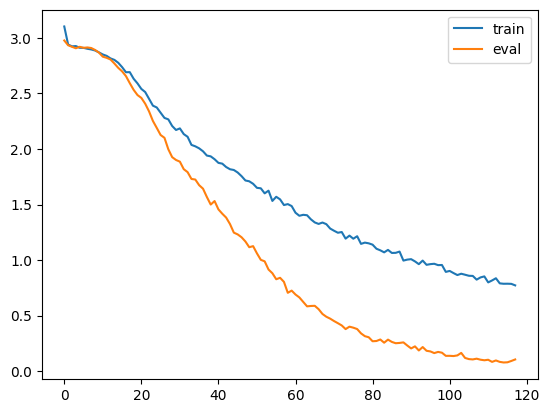

In [10]:
if TRAIN_MODEL:
    # plot the losses over the epochs 
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.legend()
    plt.savefig(os.path.join(RESULTS_PATH, 'losses.png'))

    plt.show()


    # save the vocabularies
    INPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'input_vocab.txt'))
    OUTPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'output_vocab.txt'))

     # save the model hyperparameters in a file txt
    with open(os.path.join(RESULTS_PATH, 'model_hyperparameters.txt'), 'w') as f:

        f.write(f'----------OPTIMIZATION PARAMETERS----------\n')
        f.write(f'DATE: {time.strftime("%Y%m%d-%H%M%S")}\n')
        f.write(f'DATASET_PATH: {DATASET_PATH}\n')
        f.write(f'SEED: {SEED}\n')
        f.write(f'INPUT_SIZE: {INPUT_VOCAB_SIZE}\n')
        f.write(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}\n')
        f.write(f'LEVELS: {LEVELS}\n')
        f.write(f'HIDDEN_UNITS: {HIDDEN_UNITS}\n')
        f.write(f'NUM_CHANNELS: {NUM_CHANNELS}\n')
        f.write(f'OUTPUT_SIZE: {OUTPUT_VOCAB_SIZE}\n')
        f.write(f'LOSS_WEIGTHS: {LOSS_WEIGTHS}\n')
        f.write(f'LEARNING_RATE: {LEARNING_RATE}\n')
        f.write(f'BATCH_SIZE: {BATCH_SIZE}\n')
        f.write(f'EPOCHS: {EPOCHS}\n')
        f.write(f'BEST_LOSS: {best_loss}\n')
        f.write(f'BEST_MODEL_EPOCH: {best_model_epoch}\n')
        f.write(f'------------------------------------------\n')

In [13]:
# Load the best saved model.
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# select a genere to be predicted
generes = ['blues', 'rock_excited', 'rock_relax']
genere = generes[0]

# get a sample to be predicted
sample_path = os.path.join(DATASET_PATH, f'test/drum_{genere}.mid')
sample = INPUT_TOK.midi_to_tokens(sample_path, update_vocab=False) [0]
print(sample[0])
sample = torch.LongTensor(sample).to(device)

# Get the last sequence from the batch and unsqueeze it to add a batch dimension.
sample = sample[-1].unsqueeze(0)

# Mask the last bar of the input data.
sample = torch.cat((sample[:, :BAR_LENGTH*3], torch.ones([1, BAR_LENGTH], dtype=torch.long)), dim = 1)

# Make the prediction.
prediction = model(sample)
prediction = prediction.contiguous().view(-1, OUTPUT_VOCAB_SIZE)

# Get the predicted tokens.
predicted_tokens = torch.argmax(prediction, 1)

# Get the predicted sequence.
predicted_sequence = predicted_tokens.cpu().numpy().tolist()

# Convert the predicted sequence to MIDI.
out_file_path = os.path.join(RESULTS_PATH, f'predicted_{genere}.mid')
pitch_ticks_list =  OUTPUT_TOK.tokens_to_midi(predicted_sequence, out_file_path) # midi is a pretty midi object

# check 
predicted_sequence_string = []
for id in predicted_sequence:
    predicted_sequence_string.append(OUTPUT_TOK.VOCAB.idx2word[id])
print(predicted_sequence_string)
print(pitch_ticks_list)

[1 2 2 2 2 2 0 3 4 4 4 4 5 6 7 7 7 7 0 0 3 4 4 4 4 1 2 8 8 8 8 0 0 3 4 4 4
 5 6 6 7 7 7 0 3 4 4 4 3 1 2 8 8 8 8 0 9 10 10 10 11 12 13 7 7 7 7 0 0 9
 10 10 10 1 2 8 8 8 8 8 0 9 10 10 10 5 6 7 7 7 7 7 9 10 10 10 9 1 2 8 8 8
 8 0 9 10 10 10 10 5 6 7 7 7 7 7 9 10 10 10 14 15 16 8 8 8 8 8 0 0 0 0 5 7
 7 7 7 7 0 3 4 4 4 4 1 8 8 8 8 8 0 3 4 4 4 4 5 6 7 7 7 7 0 3 4 4 4 4 1 8 8
 8 8 8 0 0 3 4 4 4 5 6 6 7 7 7 0 0 3 4 4 17]
MIDI file saved at results\20240624-165650\predicted_blues.mid
['43f', '48f', '48f', '50f', '50f', '50f', '50f', '50f', '43fS', '43f', '43f', 'O', '47fS', '47f', '47f', '47f', '47f', '47f', 'O', '47fS', '47f', '47f', 'O', 'O', '50fS', '50f', '50f', '50f', '50f', 'O', 'O', 'O', '50fS', '50f', '50f', 'O', '53fS', '53f', '53f', 'O', '52fS', '52f', 'O', 'O', '50fS', '50f', '50f', 'O', '43fS', '43f', '43f', '43f', '43f', '43f', 'O', 'O', '43fS', '43f', '43f', 'O', '47fS', '47f', '47f', '47f', '47f', '47f', '47f', 'O', 'O', '47fS', '47f', 'O', 'O', '50fS', '50f', '50f', '50f', '50f'